# 0.0 Imports

In [1]:
import math
import pandas as pd
import numpy  as np
import seaborn as sns
import inflection
import matplotlib.pyplot    as plt
from pandas_profiling import ProfileReport

from sklearn import metrics as m
from sklearn import cluster as c
from sklearn.preprocessing import MinMaxScaler


from IPython.core.display import HTML
from IPython.display import Image

## 0.1 Load Data

In [2]:
df = pd.read_csv('../data/raw/CC_GENERAL.csv')

## 0.2 Rename Columns

In [3]:
old_cols = df.columns.tolist()

snakecase = lambda x: inflection.underscore(x)

new_cols = list(map(snakecase, old_cols))

# Rename columns
df.columns = new_cols

## 0.3 Helper Functions

In [4]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
def df_performance(clusters, sil_list, db_list):
    df = pd.DataFrame({'Silhouette Score': sil_list,
                            'DB Index':db_list}).T
    df.columns = clusters
    df = df.style.highlight_max(color='lightgreen',axis=1)
    return df    
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [5]:
def descriptive_statistics(num):
    # Central Tendency - mean, median

    ct1 = pd.DataFrame(num.apply(np.mean)).T
    ct2 = pd.DataFrame(num.apply(np.median)).T

    # Dispersion - std, min, max, range, skew, curtosis
    d1 = pd.DataFrame(num.apply(min)).T
    d2 = pd.DataFrame(num.apply(max)).T
    d3 = pd.DataFrame(num.apply(lambda x: x.max()-x.min())).T
    d4 = pd.DataFrame(num.apply(np.std)).T
    d5 = pd.DataFrame(num.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num.apply(lambda x: x.kurtosis())).T

    ctd = pd.concat([ct1,ct2,d1,d2,d3,d4,d5,d6]).T.reset_index()
    ctd.columns = ['features', 'mean','median','min','max','range','std','skew','kurtosis']
    return ctd

# 1.0 Data Description


In [6]:
df1 = df.copy()

## 1.1 Feature Description

* CUSTID : Identification of Credit Card holder (Categorical)
* BALANCE : Balance amount left in their account to make purchases (
* BALANCEFREQUENCY : How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)
* PURCHASES : Amount of purchases made from account
* ONEOFFPURCHASES : Maximum purchase amount done in one-go
* INSTALLMENTSPURCHASES : Amount of purchase done in installment
* CASHADVANCE : Cash in advance given by the user
* PURCHASESFREQUENCY : How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased)
* ONEOFFPURCHASESFREQUENCY : How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased)
* PURCHASESINSTALLMENTSFREQUENCY : How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)
* CASHADVANCEFREQUENCY : How frequently the cash in advance being paid
* CASHADVANCETRX : Number of Transactions made with "Cash in Advanced"
* PURCHASESTRX : Numbe of purchase transactions made
* CREDITLIMIT : Limit of Credit Card for user
* PAYMENTS : Amount of Payment done by user
* MINIMUM_PAYMENTS : Minimum amount of payments made by user
* PRCFULLPAYMENT : Percent of full payment paid by user
* TENURE : Tenure of credit card service for user

## 1.2 Data Dimensions

In [7]:
print('The dataset has {} columns'.format(df1.shape[1]))
print('The dataset has {} rows'.format(df1.shape[0]))

The dataset has 18 columns
The dataset has 8950 rows


## 1.3 Data Types

In [8]:
# Right datatype by default
df1.dtypes

cust_id                              object
balance                             float64
balance_frequency                   float64
purchases                           float64
oneoff_purchases                    float64
installments_purchases              float64
cash_advance                        float64
purchases_frequency                 float64
oneoff_purchases_frequency          float64
purchases_installments_frequency    float64
cash_advance_frequency              float64
cash_advance_trx                      int64
purchases_trx                         int64
credit_limit                        float64
payments                            float64
minimum_payments                    float64
prc_full_payment                    float64
tenure                                int64
dtype: object

## 1.4 Check NAs


In [9]:
df1.isna().sum()[df1.isna().sum()>0]

credit_limit          1
minimum_payments    313
dtype: int64

## 1.5 Fillout NAs 

In [10]:
# Filling  0 when Minimum Payment is NA and Payment is 0
df1['minimum_payments'] = df1.apply(lambda x: 0 if (math.isnan(x['minimum_payments'])) & (x['payments']==0) else x['minimum_payments'], axis=1)

# There are 73 Minimum Payments that are not 0, so we input the Payments value itself
df1['minimum_payments'] = df1.apply(lambda x: x['payments'] if math.isnan(x['minimum_payments'])else x['minimum_payments'], axis=1)

# Fill the single Credit limit NA with the median value (3000)
df1.credit_limit.fillna(3000, inplace=True)

# Check NAS
df1.isna().sum().any()

False

## 1.6 Descriptive Statistics

In [11]:
num = df1.drop('cust_id', axis=1)

In [12]:
descriptive_statistics(num)

,features,mean,median,min,max,range,std,skew,kurtosis
0,balance,1564.474828,873.385231,0.0,19043.13856,19043.13856,2081.415590,2.393386,7.674751
1,balance_frequency,0.877271,1.000000,0.0,1.00000,1.00000,0.236891,-2.023266,3.092370
2,purchases,1003.204834,361.280000,0.0,49039.57000,49039.57000,2136.515413,8.144269,111.388771
3,oneoff_purchases,592.437371,38.000000,0.0,40761.25000,40761.25000,1659.795184,10.045083,164.187572
4,installments_purchases,411.067645,89.000000,0.0,22500.00000,22500.00000,904.287592,7.299120,96.575178
5,cash_advance,978.871112,0.000000,0.0,47137.21176,47137.21176,2097.046713,5.166609,52.899434
6,purchases_frequency,0.490351,0.500000,0.0,1.00000,1.00000,0.401348,0.060164,-1.638631
7,oneoff_purchases_frequency,0.202458,0.083333,0.0,1.00000,1.00000,0.298319,1.535613,1.161846
8,purchases_installments_frequency,0.364437,0.166667,0.0,1.00000,1.00000,0.397426,0.509201,-1.398632
9,cash_advance_frequency,0.135144,0.000000,0.0,1.50000,1.50000,0.200110,1.828686,3.334734


# 2.0 Feature FIltering

In [13]:
df2 = df1.copy()

In [14]:
# Modify customers with cash_advance_frequency above 1
df2.loc[df2.cash_advance_frequency > 1 , 'cash_advance_frequency'] = 1

In [15]:
df2.shape

(8950, 18)

In [16]:
df2.loc[(df2.purchases ==0)&(df2.oneoff_purchases==0)].shape[0]

2044

# 3.0 Feature Engeneering

In [17]:
df3 = df2.copy()

In [18]:
# Pagamento à vista ou não
df3['is_oneoff_or_not'] =  df3['oneoff_purchases'].apply(lambda x: 0 if x== 0.00 else 1)

# Gasto médio por compra 
#df3['avg_ticket_purchases'] = df3['purchases'] / df3['purchases_trx']

# Gasto médio por transação total
#df3['avg_ticket_expenses'] = (df3['purchases'] + df3['cash_advance']) / (df3['purchases_trx'] + df3['cash_advance_trx'])

#Soma das despesas / soma dos pagamentos
# df3['debt_rate'] = (df3['purchases'] + df3['cash_advance']) / (df3['payments'] + df3['minimum_payments'])

# Percentual de uso do limite do cartão
df3['credit_limit_rate'] = (df3['purchases'] + df3['cash_advance']) / (6 * df3['credit_limit'])

In [19]:
df3.apply(max)

cust_id                                  C19190
balance                             19043.13856
balance_frequency                           1.0
purchases                              49039.57
oneoff_purchases                       40761.25
installments_purchases                  22500.0
cash_advance                        47137.21176
purchases_frequency                         1.0
oneoff_purchases_frequency                  1.0
purchases_installments_frequency            1.0
cash_advance_frequency                      1.0
cash_advance_trx                            123
purchases_trx                               358
credit_limit                            30000.0
payments                            50721.48336
minimum_payments                    76406.20752
prc_full_payment                            1.0
tenure                                       12
is_oneoff_or_not                              1
credit_limit_rate                     18.922599
dtype: object

# 4.0 Exploratory Data Analysis (EDA)

In [20]:
df4 = df3.copy()

## 3.1 Univariate Analysis

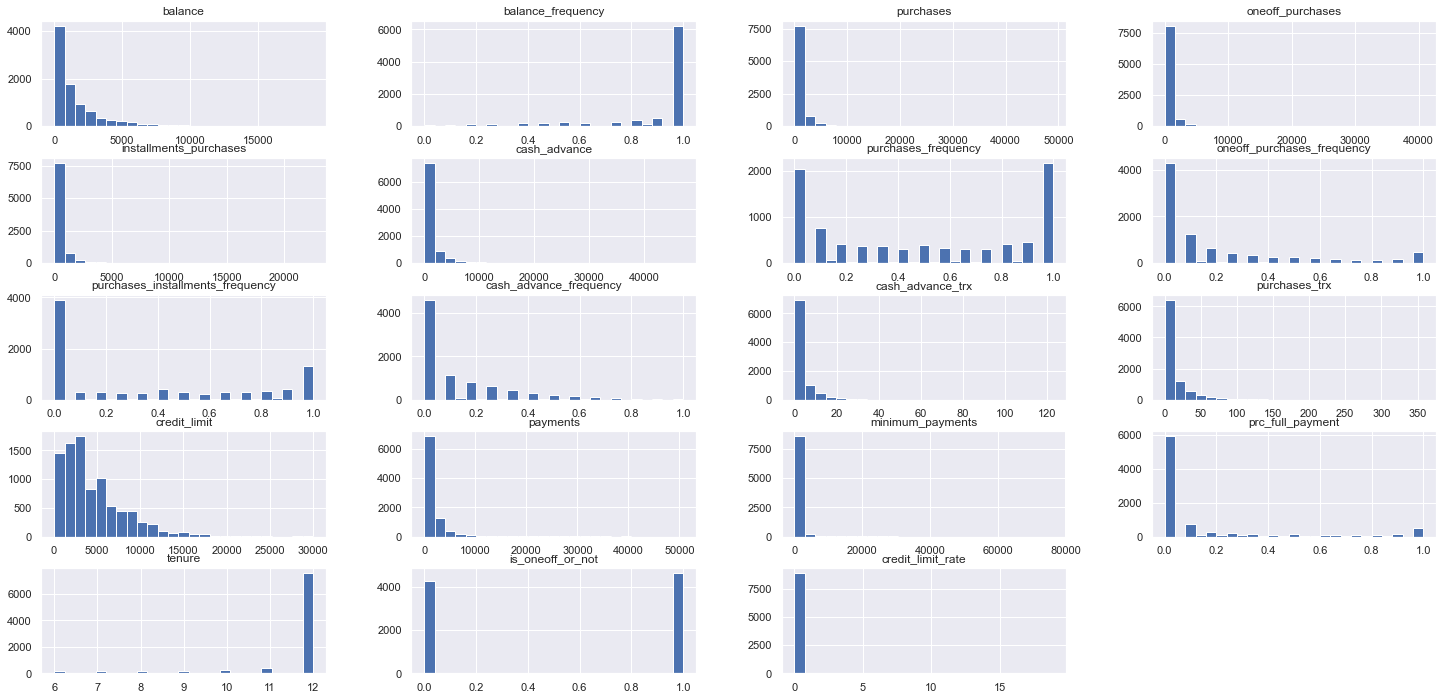

In [21]:
num = df4.drop('cust_id', axis=1)
num.hist(bins=25);

In [22]:
# Using Pandas Profile
# profile = ProfileReport(num, title='Bank Marketing Strategy - Exploratory Data Analysis', html={'style':{'full_width':True}})
# profile.to_file(output_file="EDA1.html")

### 3.1.1 Outlier Analysis

#### Balance

```balance``` does not see to have outliers as part of the phenomenon

In [23]:
num['balance'].sort_values(ascending=False).head(20)

138     19043.13856
4140    18495.55855
5488    16304.88925
6629    16259.44857
5281    16115.59640
2361    15532.33972
520     15258.22590
585     15244.74865
4708    15155.53286
883     14581.45914
643     14411.95798
124     14224.11541
3806    14100.25110
4089    13968.47957
5913    13777.37772
723     13774.74154
708     13763.47358
153     13673.07961
501     13479.28821
7962    13318.65912
Name: balance, dtype: float64

#### Purchases

- 22.8% ZERO purchases (1967 count)
- ```purchases``` does not seem to have outliers as part of the phenomenon

In [24]:
num['purchases'].sort_values(ascending=False).head(20)

550     49039.57
501     41050.40
1256    40040.71
1604    38902.71
3937    35131.16
273     32539.78
1641    31299.35
587     27957.68
3698    27790.42
7046    26784.62
970     26582.34
507     26402.39
1447    25615.07
1585    25378.36
1190    22746.81
5260    22500.00
2970    22381.97
5358    22101.78
138     22009.92
1560    21802.60
Name: purchases, dtype: float64

#### <font color='red'> One-Off Purchases </font>

Could ```oneoff_purchase``` have outliers, like the first four values?

In [25]:
num['oneoff_purchases'].sort_values(ascending=False).head(20)

550     40761.25
501     40624.06
3937    34087.73
1604    33803.84
273     26547.43
7046    26514.32
1447    25122.77
1256    24543.52
587     23032.97
507     22257.39
5358    22101.78
1560    21802.60
1585    20646.07
2970    19150.02
1641    19064.30
4220    17945.00
3652    16864.56
1190    15795.42
970     15158.90
3698    14605.99
Name: oneoff_purchases, dtype: float64

#### <font color='red'> Installments Payments </font>

- Zeros 43.4% (total 3747)
- Maybe one outlier (22500)

In [26]:
num['installments_purchases'].sort_values(ascending=False).head(20)

5260    22500.00
1256    15497.19
3181    14686.10
3698    13184.43
2823    12738.47
138     12560.85
1709    12541.00
1433    12375.00
1641    12235.05
645     12128.94
970     11423.44
393     10009.93
511      9268.32
229      9251.65
4515     8409.93
4540     8391.55
550      8278.32
560      7787.98
4282     7740.27
4376     7739.48
Name: installments_purchases, dtype: float64

#### <font color= 'red'>Cash Advance </font>

- Zeros 51.3% (total 4431)
- Indicates outlier in value 47137

In [27]:
num['cash_advance'].sort_values(ascending=False).head(20)

2159    47137.21176
1059    29282.10915
71      27296.48576
7254    26268.69989
7645    26194.04954
2454    23130.82106
883     22665.77850
6371    21943.84942
3806    20712.67008
6455    20277.33112
3555    19862.87844
5358    19513.47483
842     18857.05847
182     17661.49486
2240    17278.53864
5903    16981.84677
1710    16323.64243
789     16037.32794
274     15452.97758
4515    15133.53213
Name: cash_advance, dtype: float64

#### <font color= 'black'>Cash Advance Trx </font>

- Same amount of Zero as Cash Advance
- Does not seem to have outliers

In [28]:
num['cash_advance_trx'].sort_values(ascending=False).head(20)

542     123
2159    123
8315    123
3545    110
1913    107
5287     93
5319     80
5116     71
7645     69
3261     63
658      62
735      62
7723     62
5919     61
2240     56
1217     53
1925     52
615      52
557      52
610      51
Name: cash_advance_trx, dtype: int64

#### Purchases Trx

- Same amount of Zeros as Purchases
- Does not seem to have outliers

In [29]:
num['purchases_trx'].sort_values(ascending=False).head(20)

1256    358
3181    347
3937    344
4784    309
4515    308
2823    298
5575    274
1912    273
2515    254
5048    248
1412    248
2067    232
415     229
5771    224
560     222
645     219
125     217
153     216
138     216
1767    208
Name: purchases_trx, dtype: int64

#### Credit Limit

- No zeros
- Does not seem to have outliers
- The highest values is 10x bigger than the most commom values (3000)

In [30]:
# Highest values
num.credit_limit.sort_values(ascending=False).head(20)

4905    30000.0
7046    30000.0
970     28000.0
3659    25000.0
200     23000.0
5260    23000.0
550     22500.0
4140    22000.0
143     21500.0
1514    21500.0
326     21000.0
3691    21000.0
1667    20500.0
690     20000.0
178     20000.0
733     20000.0
153     20000.0
4919    20000.0
155     20000.0
502     20000.0
Name: credit_limit, dtype: float64

In [31]:
# Most common values
num.credit_limit.value_counts().sort_values(ascending=False).head(20)

3000.0     785
1500.0     722
1200.0     621
1000.0     614
2500.0     612
4000.0     506
6000.0     463
5000.0     389
2000.0     371
7500.0     277
7000.0     274
4500.0     244
6500.0     211
1800.0     202
3500.0     192
9000.0     183
8000.0     157
10000.0    154
8500.0     153
500.0      121
Name: credit_limit, dtype: int64

#### Payments

- Does not seem to have outliers

In [32]:
num['payments'].sort_values(ascending=False).head(20)

4220    50721.48336
550     46930.59824
4668    40627.59524
5358    39461.96580
2159    39048.59762
501     36066.75068
1604    35843.62593
2915    34107.07499
1256    33994.72785
6371    33486.31044
341     32048.61220
854     31698.41902
7046    30029.01496
1155    29272.48607
1458    28988.97388
3937    28896.66522
71      28232.69446
1059    28150.97869
3698    27839.82354
587     27255.00752
Name: payments, dtype: float64

#### <font color='red'>Minimum Payments </font>

- Minimum and maximum values of ```payments``` and ```minimum_payments``` do not match

In [33]:
# Maximum values
num['minimum_payments'].sort_values(ascending=False).head(20)

4376    76406.20752
7132    61031.61860
5657    56370.04117
4462    50260.75947
5830    43132.72823
5968    42629.55117
567     38512.12477
5298    31871.36379
1130    30528.43240
1155    29272.48607
6635    29019.80288
2774    28483.25483
387     27631.45072
1683    27146.02678
6623    26873.51595
2788    26378.90782
2423    26143.17049
4658    25697.63772
8026    25312.16069
697     24302.09819
Name: minimum_payments, dtype: float64

In [34]:
# Minimum Values
num['minimum_payments'].sort_values(ascending=True).head(20)

1651    0.0
7763    0.0
7831    0.0
5828    0.0
4082    0.0
7919    0.0
4013    0.0
7939    0.0
7952    0.0
7964    0.0
422     0.0
3907    0.0
3902    0.0
412     0.0
3873    0.0
406     0.0
1334    0.0
404     0.0
3844    0.0
8031    0.0
Name: minimum_payments, dtype: float64

## 3.2 Bivariate Analysis

## 3.3. Multivariate Analysis

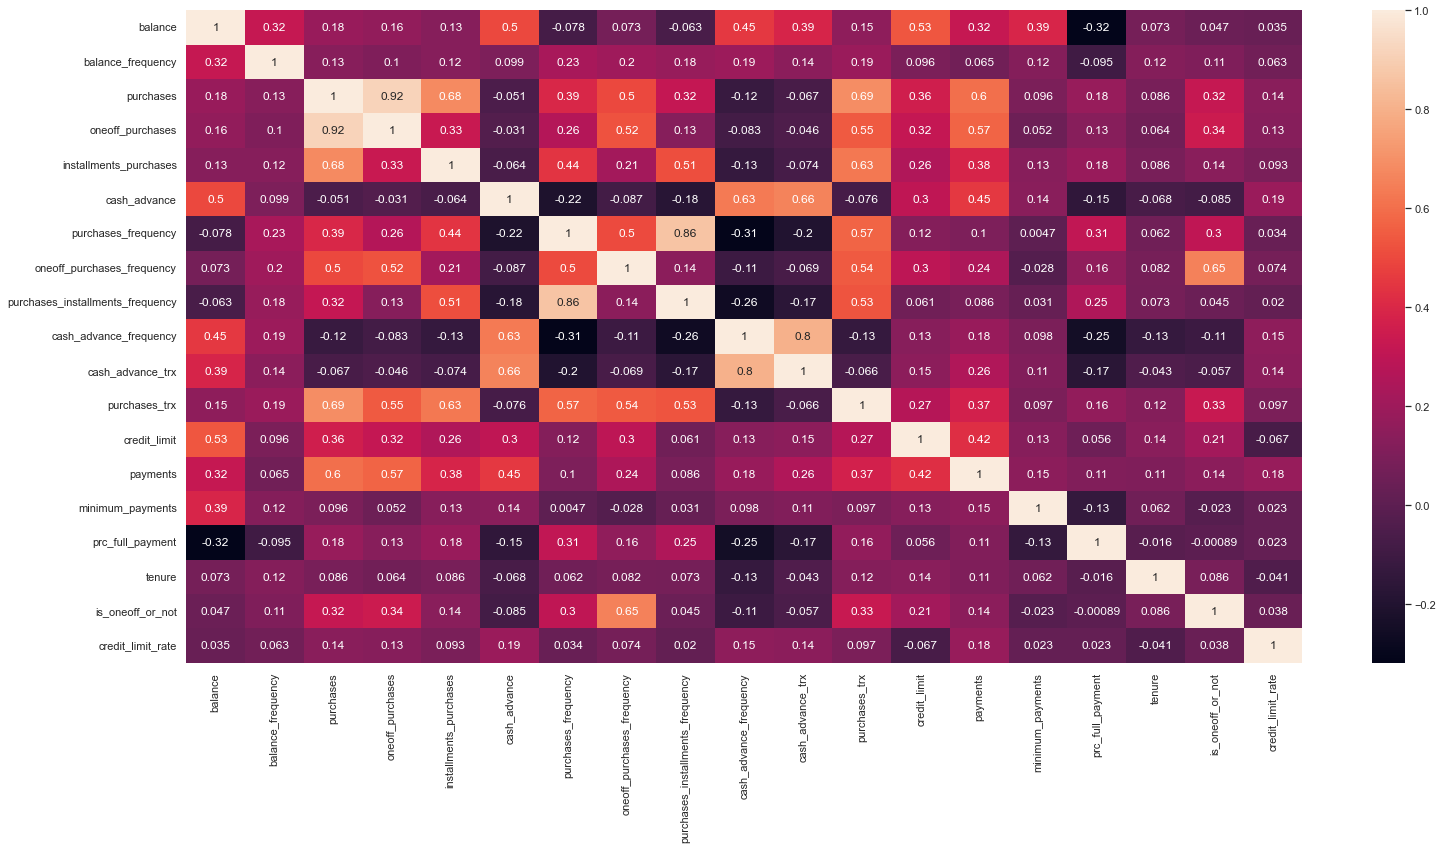

In [35]:
sns.heatmap(num.corr(method='pearson'),annot=True);

# 5.0 Data Preparation

In [36]:
df5 = df4.copy()

In [37]:
mms = MinMaxScaler()

df5['balance'] = mms.fit_transform(df5[['balance']].values)
df5['balance_frequency'] = mms.fit_transform(df5[['balance_frequency']].values)
df5['purchases'] = mms.fit_transform(df5[['purchases']].values)
df5['oneoff_purchases'] = mms.fit_transform(df5[['oneoff_purchases']].values)
df5['installments_purchases'] = mms.fit_transform(df5[['installments_purchases']].values)
df5['cash_advance'] = mms.fit_transform(df5[['cash_advance']].values)
df5['purchases_frequency'] = mms.fit_transform(df5[['purchases_frequency']].values)
df5['oneoff_purchases_frequency'] = mms.fit_transform(df5[['oneoff_purchases_frequency']].values)
df5['purchases_installments_frequency'] = mms.fit_transform(df5[['purchases_installments_frequency']].values)
df5['cash_advance_frequency'] = mms.fit_transform(df5[['cash_advance_frequency']].values)
df5['cash_advance_trx'] = mms.fit_transform(df5[['cash_advance_trx']].values)
df5['purchases_trx'] = mms.fit_transform(df5[['purchases_trx']].values)
df5['credit_limit'] = mms.fit_transform(df5[['credit_limit']].values)
df5['payments'] = mms.fit_transform(df5[['payments']].values)
df5['minimum_payments'] = mms.fit_transform(df5[['minimum_payments']].values)
df5['prc_full_payment'] = mms.fit_transform(df5[['prc_full_payment']].values)
df5['tenure'] = mms.fit_transform(df5[['tenure']].values)

# New features
df3['credit_limit_rate'] = mms.fit_transform(df5[['credit_limit_rate']].values)


In [38]:
# Check data preparation
df5.head()

,cust_id,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure,is_oneoff_or_not,credit_limit_rate
0,C10001,0.002148,0.818182,0.001945,0.000000,0.00424,0.000000,0.166667,0.000000,0.083333,0.000000,0.00000,0.005587,0.031720,0.003979,0.001826,0.000000,1.0,0,0.015900
1,C10002,0.168169,0.909091,0.000000,0.000000,0.00000,0.136685,0.000000,0.000000,0.000000,0.250000,0.03252,0.000000,0.232053,0.080893,0.014035,0.222222,1.0,0,0.153403
2,C10003,0.131026,1.000000,0.015766,0.018968,0.00000,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.033520,0.248748,0.012264,0.008210,0.000000,1.0,1,0.017182
3,C10004,0.087521,0.636364,0.030567,0.036775,0.00000,0.004366,0.083333,0.083333,0.000000,0.083333,0.00813,0.002793,0.248748,0.000000,0.000000,0.000000,1.0,1,0.037884
4,C10005,0.042940,1.000000,0.000326,0.000393,0.00000,0.000000,0.083333,0.083333,0.000000,0.000000,0.00000,0.002793,0.038397,0.013374,0.003204,0.000000,1.0,1,0.002222


# 6.0 Feature Selection



In [39]:
df6 = df5.copy()

# 7.0 Hyperparameter Fine-Tunning

In [40]:
df7 = df6.copy()
X = df6.drop('cust_id', axis=1)

# Set k clusters
clusters = np.arange(2,10,1)

In [41]:
kmeans_list  = []
dv_list = []
for k in clusters:
    # Model definition
    kmeans = c.KMeans(n_clusters=k, random_state=42)
    
    # Model training
    kmeans.fit(X)
    
    # Model Prediction
    labels = kmeans.predict(X)
    
    # Model Performance
    sil_score = m.silhouette_score(X, labels, metric='euclidean')
    dv = m.davies_bouldin_score(X, labels)
    
    kmeans_list.append(sil_score)
    dv_list.append(dv)
    
df_performance(clusters, kmeans_list, dv_list)

,2,3,4,5,6,7,8,9
Silhouette Score,0.329061,0.339406,0.371035,0.365071,0.351243,0.355071,0.334872,0.333271
DB Index,1.375338,1.074274,1.115746,1.250737,1.001326,1.114058,1.136724,1.109648


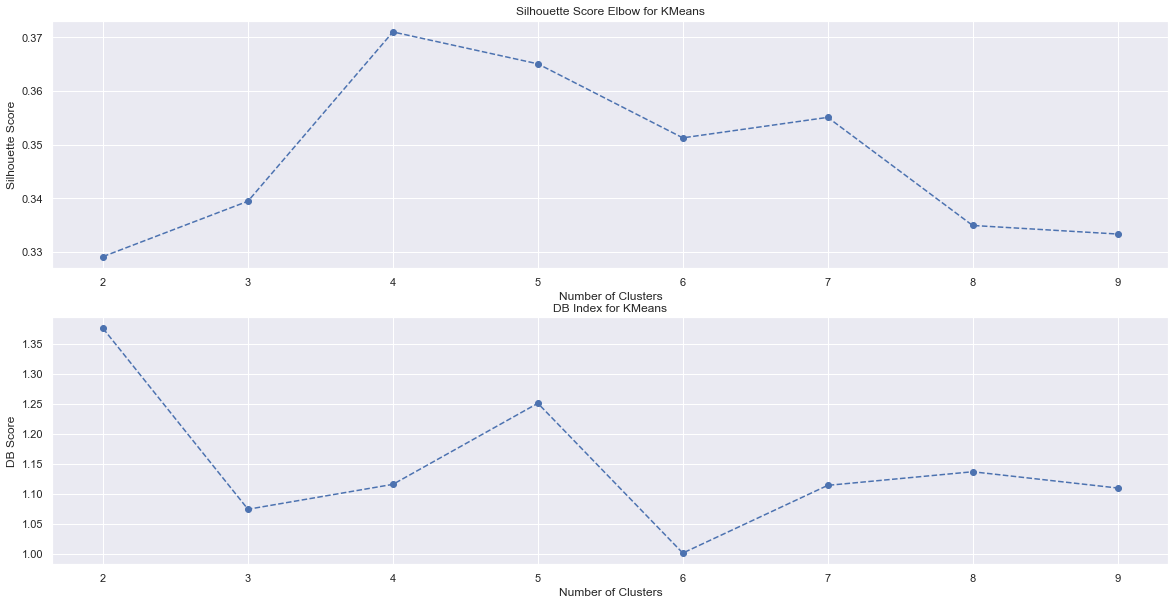

In [42]:
plt.figure(figsize=(20,10))

# Plot Silhouette Score Elbow
plt.subplot(2,1,1)
plt.plot(clusters, kmeans_list, linestyle='--',marker='o',color='b');
plt.title('Silhouette Score Elbow for KMeans');
plt.ylabel('Silhouette Score');
plt.xlabel('Number of Clusters');

# Plot DB Index
plt.subplot(2,1,2)
plt.plot(clusters, dv_list, linestyle='--',marker='o',color='b');
plt.title('DB Index for KMeans');
plt.ylabel('DB Score');
plt.xlabel('Number of Clusters');

plt.show();

# 8.0 Machine Learning Modelling

In [43]:
df8 = df7.copy()

# 9.0 Cluster Analysis

In [44]:
df9 = df8.copy()

# 10.0 EDA - Cluster Profiles


In [45]:
df10 =df9.copy()

# 11.0 Deployment